In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from brainspace.null_models import MoranRandomization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import mne
from scipy import stats

from mni_plots import plot_parcellated_metric, bar_plot, mni_plot, plot_struct_corr

### Paths and names

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
res_dir = "Results_gamma"
res_path = data_path.joinpath(res_dir)
data_name = "tau"

Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

## 1) Plot of parcellated brain areas

In [9]:
df_plot = {
    "W": pd.read_csv(res_path.joinpath(f"{data_name}_parc_W.csv"), index_col=0),
    "N3": pd.read_csv(res_path.joinpath(f"{data_name}_parc_N3.csv"), index_col=0),
    "R": pd.read_csv(res_path.joinpath(f"{data_name}_parc_R.csv"), index_col=0),
}

In [11]:
minmax_stages = {"W": (15, 40), "N3": (35, 105), "R": (15, 55)}
# minmax_stages = {"W": (6, 9.5), "N3": (6, 9.5), "R": (6, 9.5)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:

    fig, ax = plot_parcellated_metric(
        df_plot[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="inferno",
    )
    # plt.show()

    fig.savefig(res_path.joinpath(f"{data_name}_parc_{stage}.png"), dpi=300)
    plt.close(fig)


Using pyvistaqt 3d backend.



### Maps of differences

In [13]:
df_plot_W_N3 = df_plot["N3"] - df_plot["W"]  # [0, 75], [-2, 2]
df_plot_W_R = df_plot["R"] - df_plot["W"]  # [-10, 30]

# NREM3 figure
fig, ax = plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(0, 75),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]"
)
fig.savefig(res_path.joinpath(f"{data_name}_parc_N3-W.png"), dpi=300)
plt.close(fig)

# REM figure
fig, ax = plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    log_scale=False,
    minmax=(0, 75),
    zero_center=False,
    title="REM - Wake",
    cmap="Reds",
    label="Timescale difference [ms]"
)
fig.savefig(res_path.joinpath(f"{data_name}_parc_R-W.png"), dpi=300)
plt.close(fig)

## 2) Plot of macro-parcels

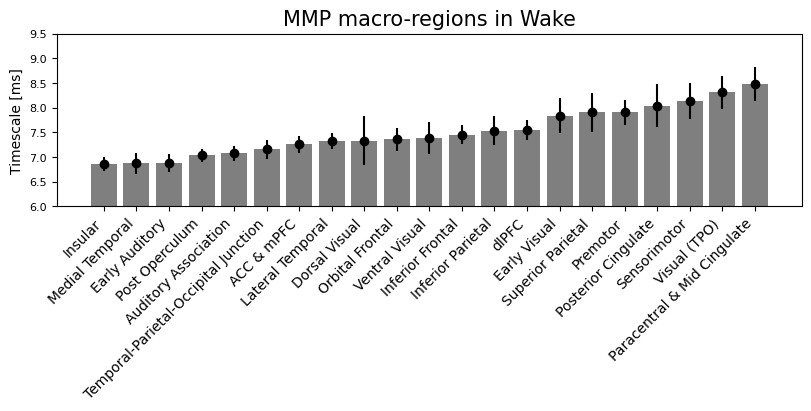

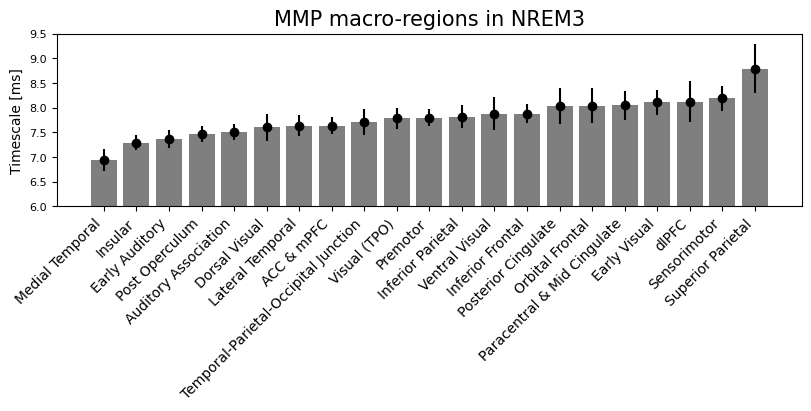

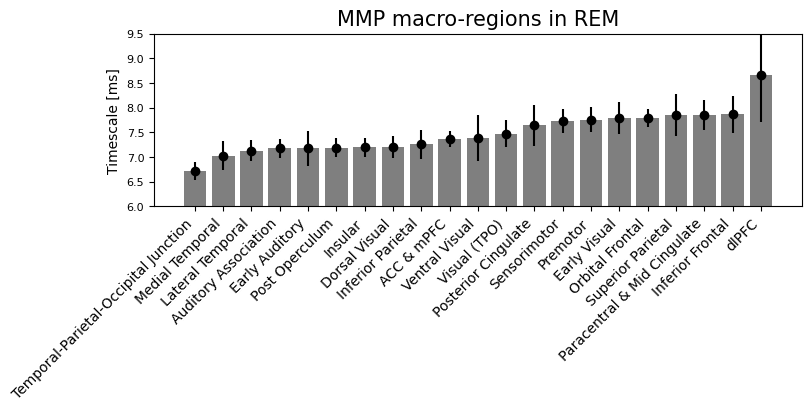

In [14]:
minmax_stages = {"W": (15, 40), "N3": (35, 105), "R": (15, 60)}
# minmax_stages = {"W": (6, 9.5), "N3": (6, 9.5), "R": (6, 9.5)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:
    df_plot = pd.read_csv(
        res_path.joinpath(f"{data_name}_macro_mmp_{stage}.csv"), index_col=0
    )

    fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
    ax = bar_plot(
        ax,
        df_plot,
        minmax_stages[stage],
        title="MMP macro-regions in " + title_dict[stage],
        y_label="Timescale [ms]"
    )
    plt.show()
    fig.savefig(res_path.joinpath(f"{data_name}_macro_mmp_{stage}.png"), dpi=300, bbox_inches='tight')


## 3) Scatter plot of MNI macro-regions

In [26]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per stage
df_plot_all_stages = []
for stage in ["W", "N3", "R"]:
    df_plot = pd.read_csv(
        res_path.joinpath(f"{data_name}_macro_mni_{stage}.csv"), index_col=0
    )
    df_plot.rename(columns={"stage": "cond", "tau": "Timescale [ms]"}, inplace=True)
    df_plot_all_stages.append(df_plot)

    df_regions = df_plot.groupby("lobe")["region"].unique()
    df_regions = df_regions.loc[
        ["Occipital", "Parietal", "Frontal", "Insula", "Temporal"]
    ]
    df_plot = df_plot.drop(columns=["lobe", "r2", "exp"])
    df_regions_len = df_regions.apply(lambda x: len(x)).cumsum()

    fig, ax = mni_plot(
        df_plot,
        df_regions_len,
        reg_order=np.concatenate(df_regions.to_list()),
        conds_order=[stage],
        title=stage,
    )
    fig.savefig(
        res_path.joinpath(f"{data_name}_macro_mni_{stage}.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.close(fig)

# Finally, plot all regions together
df_plot_all_stages = pd.concat(df_plot_all_stages, ignore_index=True)
df_regions = df_plot_all_stages.groupby("lobe")["region"].unique()
df_regions = df_regions.loc[["Occipital", "Parietal", "Frontal", "Insula", "Temporal"]]
df_plot_all_stages.drop(columns=["lobe", "r2", "exp"], inplace=True)
df_regions_len = df_regions.apply(lambda x: len(x)).cumsum()

fig, ax = plt.subplots(figsize=(40, 5), layout="constrained")
fig, ax = mni_plot(
    df_plot_all_stages,
    df_regions_len * 2 - 1,
    reg_order=np.concatenate(df_regions.to_list()),
    conds_order=["W", "N3", "R"],
    sep=0.5,
    title="Comparison between stages",
    ax=ax
)

fig.savefig(
    res_path.joinpath(f"{data_name}_macro_mni_all_stages.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.close(fig)

## Correlation with structure

In [6]:
df_struct = pd.read_csv(data_path.joinpath("df_structural_avg.csv"), index_col=0)
#Randomization of map
df_parcel_geo = pd.read_csv(data_path.joinpath("LeftParcelGeodesicDistmat.txt"), header=None, delimiter=' ')
w_igd = 1/(df_parcel_geo.values + np.eye(len(df_parcel_geo)))  # inverse
tau_msr = MoranRandomization(n_rep=1000, procedure='singleton', tol=1e-6, random_state=29)
tau_msr.fit(w_igd)

MoranRandomization(n_rep=1000, random_state=29, tol=1e-06)

Correlation between T1T2 and tau in W: rho=0.23610605265594614, p-corr=0.078 (p=0.0014184867784993414)
Correlation between T1T2 and tau in N3: rho=0.5804170910624813, p-corr=0.002 (p=1.3465382200913254e-17)
Correlation between T1T2 and tau in R: rho=0.5533462966964, p-corr=0.0 (p=7.908741256174507e-16)


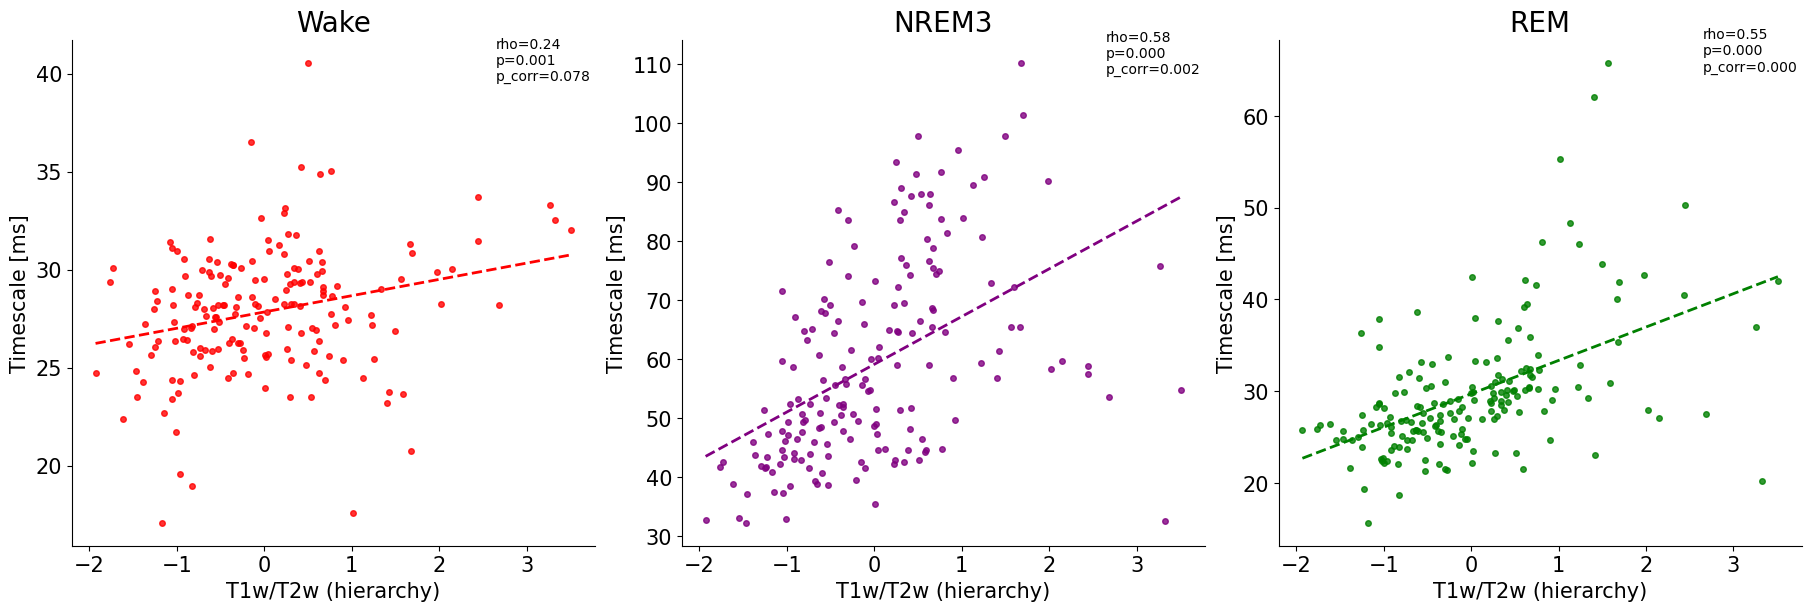

In [7]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}

fig, axs = plt.subplots(1, 3, figsize=(18, 6), layout="constrained")


for i, stage in enumerate(["W", "N3", "R"]):
    # Import dataframe
    df_plot = pd.read_csv(
        res_path.joinpath(f"{data_name}_parc_{stage}.csv"), index_col=0
    )

    axs[i] = plot_struct_corr(
        axs[i],
        stats.zscore(df_struct["T1T2"], ddof=1).to_numpy(),
        df_plot.loc[df_struct.index].to_numpy().squeeze(),
        tau_msr,
        stage=stage,
        color=color_stages[stage],
        title=title_dict[stage],
    )

fig.savefig(
    res_path.joinpath(f"{data_name}_corr_struct.png"),
    dpi=300,
    bbox_inches="tight",
)

plt.show() 
